In [1]:
import numpy as np
import os
import kagglehub
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, ds_file, labels, transform=None):
        self.transform = transform
        data_np = np.load(ds_file)
        labels_np = np.load(labels)
        self.data = torch.from_numpy(data_np)
        self.labels = torch.from_numpy(labels_np)
        self.length = data_np.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        if self.transform:
            self.data = self.transform(self.data)

        return self.data[index], self.labels[index]

Using Colab cache for faster access to the 'crowd-counting' dataset.
Path to dataset files: /kaggle/input/crowd-counting
tensor([31], dtype=torch.uint8)


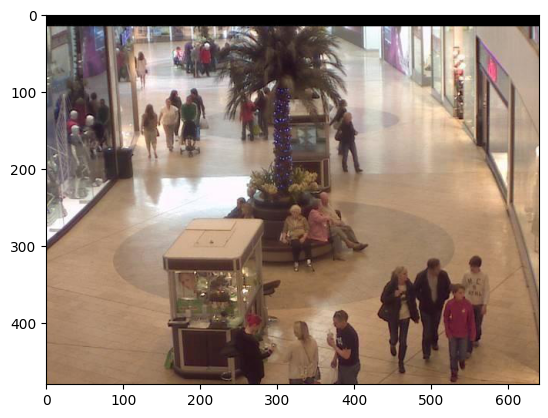

In [3]:
# Download latest version

path = kagglehub.dataset_download("fmena14/crowd-counting")

# train_data = np.load(os.path.join(path, "images.npy"))
all_data = DataSet(os.path.join(path, "images.npy"), os.path.join(path, "labels.npy"))
training_size = int(0.7 * len(all_data))
testing_size = (len(all_data)-training_size)

train_data, test_data = torch.utils.data.random_split(all_data, [training_size, testing_size])
# plt.imshow(train_data[0])
# train_data_tensor = torch.from_numpy(train_data).float()
# print(train_data_tensor.shape)
labels = np.load(os.path.join(path, "labels.npy"))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

print("Path to dataset files:", path)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)



# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)


# show images
imshow(images[0])
print(labels[0])

In [4]:
class ResNet50TransferClassif(nn.Module):
    def __init__(self, num_outputs, unlock_layers=0):
        super().__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(in_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_outputs)
        for param in self.resnet.parameters():
            param.requires_grad = False
        if unlock_layers > 0:
            layers = list(self.resnet.parameters())
            unlock_layers = min(unlock_layers, len(layers))
            for param in layers[-unlock_layers:]:
                param.requires_grad = True

    def forward(self, x):
        x = self.resnet(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def plot_accuracy_graphs(title, train_graph, test_graph, file_name):
  fig, axes = plt.subplots(1,2)
  axes[0].plot(train_graph)
  axes[0].set_title("Training Accuracy")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Error (average number of people missed)")
  axes[1].plot(test_graph)
  axes[1].set_title("Testing Accuracy")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Error (average number of people missed)")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()
  fig.savefig(file_name)

def plot_loss_graphs(title, train_graph, test_graph, file_name):
  fig, axes = plt.subplots(1,2)
  axes[0].plot(train_graph)
  axes[0].set_title("Training Loss")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Cross-Entropy Loss")
  axes[1].plot(test_graph)
  axes[1].set_title("Testing Loss")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Cross-Entropy Loss")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()
  fig.savefig(file_name)

In [6]:
def train(model, device, epochs):
    train_acc_history = np.zeros(epochs)
    test_acc_history = np.zeros(epochs)
    train_loss_history = np.zeros(epochs)
    test_loss_history = np.zeros(epochs)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(epochs):
        total = 0
        running_loss = 0.0
        running_acc = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_2d = torch.tensor(()).new_zeros((inputs.shape[0], 60))
            for j in range(inputs.shape[0]):
                labels_2d[j, labels[j].int()] = 1
            labels_2d = labels_2d.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 2, 1).float())
            loss = criterion(outputs.float(), labels_2d.float())
            loss.backward()
            optimizer.step()
            predicted = torch.argmax(outputs, 1, keepdim=True)
            total += labels.size(0)
            running_acc += torch.sum(torch.abs(predicted.float() - labels)).item()
            running_loss += loss.item()
        print(running_loss)
        train_acc_history[epoch] = running_acc / total
        train_loss_history[epoch] = running_loss / total
        total = 0
        running_loss = 0.0
        running_acc = 0.0

        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_2d = torch.tensor(()).new_zeros((inputs.shape[0], 60))
                for j in range(inputs.shape[0]):
                    labels_2d[j, labels[j].int()] = 1
                labels_2d = labels_2d.to(device)
                outputs = model(inputs.permute(0, 3, 2, 1).float())
                loss = criterion(outputs.float(), labels_2d.float())
                predicted = torch.argmax(outputs, 1, keepdim=True)
                total += labels.size(0)
                running_acc += torch.sum(torch.abs(predicted.float() - labels)).item()
                running_loss += loss.item()
        test_acc_history[epoch] = running_acc / total
        test_loss_history[epoch] = running_loss / total

    return train_acc_history, test_acc_history, train_loss_history, test_loss_history

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet50TransferClassif(60, unlock_layers=9)
model = model.to(device)
train_acc_history, test_acc_history, train_loss_history, test_loss_history = train(model, device, 50)
torch.save(model.state_dict(), 'transfer_learning_model.pth')

cuda
1212.716272354126
1123.8045325279236
1004.0039968490601
908.6276981830597
820.3293330669403
767.8670942783356
720.0061963796616
682.2065073251724
662.0791494846344
613.4906507134438
588.8428100943565
562.2651034593582
534.0984969139099
494.74592411518097
462.4831523001194
409.063239723444
364.1813818216324
353.23682501912117
318.2244827002287
281.5042994990945
253.29016736894846
228.89169228076935
220.72338153794408
201.9688996784389
194.88141391985118
183.9144139578566
140.37327600363642
122.03978381375782
151.15901327319443
131.12091689743102
100.3756350488402
108.01918378134724
108.53949062305037
116.29136714106426
103.07484528847272
96.22799469344318
102.7394222645089
79.32381776091643
88.06752622278873
92.8962769858772
87.5173674323596
82.24396903399611
71.63153164868709
74.80388078521355
71.43523069971707
62.37298909891979
47.805516358464956
66.15710226225201
78.92221247544512
66.6462642707047


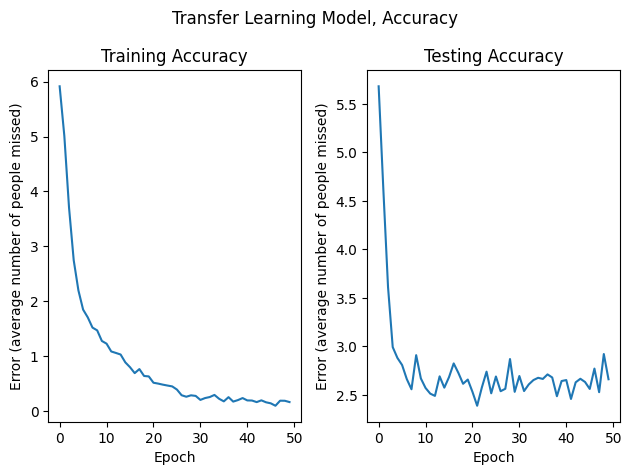

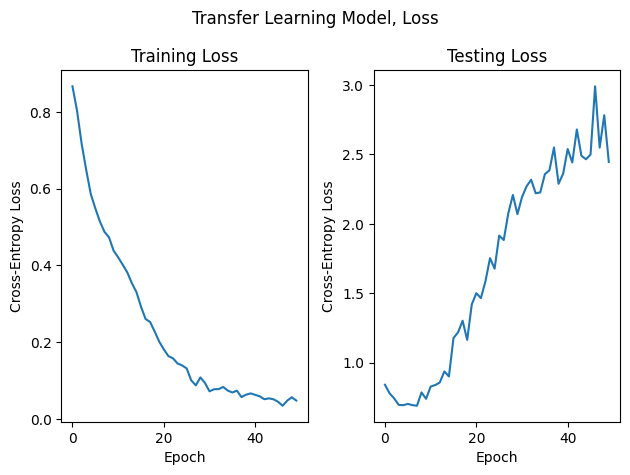

In [8]:
plot_accuracy_graphs("Transfer Learning Model, Accuracy", train_acc_history, test_acc_history, "transfer_learning_accuracy.png")
plot_loss_graphs("Transfer Learning Model, Loss", train_loss_history, test_loss_history, "transfer_learning_loss.png")

Predicted:  tensor([32], device='cuda:0') tensor([29], device='cuda:0') tensor([31], device='cuda:0') tensor([29], device='cuda:0')
Truth:  tensor([33], dtype=torch.uint8) tensor([32], dtype=torch.uint8) tensor([27], dtype=torch.uint8) tensor([28], dtype=torch.uint8)
Average error on the test images (in number of people missed): 2.660000 


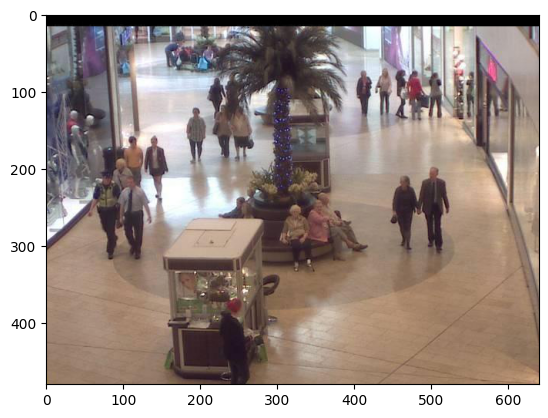

In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device).permute(0, 3, 2, 1).float())
predicted = torch.argmax(outputs, 1, keepdim=True)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))
imshow(images[0])
print('Truth: ', ' '.join('%5s' % labels[j]
                              for j in range(4)))

total = 0
total_error = 0.0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images.permute(0, 3, 2, 1).float())
        predicted = torch.argmax(outputs, 1, keepdim=True)
        total += labels.size(0)
        total_error += torch.sum(torch.abs(predicted.float() - labels)).item()

print('Average error on the test images (in number of people missed): %f ' %(
    total_error / total))